<a href="https://colab.research.google.com/github/howsam/Building-a-ChatGPT-like-Model-from-Scratch/blob/main/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <font color='#FFE15D'><b>💎 Data</b></font>

# 🔴 **Environment Setup**

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


## 🟠 `pip`

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.6 MB/s eta 0:00:00


# 🔴 **Import**

In [ ]:
import os
import re
import time
import json
import random
import string
import psutil
import pickle
from tqdm import tqdm
from pprint import pprint
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers, decoders, processors
import tiktoken

import torch
from torch.utils.data import TensorDataset, Dataset, IterableDataset, DataLoader

# 🔴 **Utils**

In [ ]:
def get_sample(dataset):
    # Randomly select an index from the training dataset
    idx = random.randint(0, len(dataset['train']))

    # Return the "text" field of the randomly selected training sample
    return dataset['train'][idx]['text']

In [ ]:
def prepare_data(tokens, seq_len):
    """
    Converts a flat list of token IDs into a 2D tensor where each row has length `seq_len`.

    Args:
        token_list (list or array-like): Flat list of token IDs.
        seq_len (int): Desired sequence length per row.

    Returns:
        torch.Tensor: 2D tensor of shape (num_sequences, seq_len).
    """

    # Trim tokens so that total length is divisible by seq_len
    n_tokens = (tokens.shape[0] // seq_len) * seq_len
    tokens = tokens[:n_tokens]

    # Reshape to 2D tensor
    return tokens.view(-1, seq_len)


# 🔴 **EDA**

## 🟠 Exploring the Dataset

In [ ]:
dataset = load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [ ]:
sample = get_sample(dataset)
pprint(sample)

('Tommy was packing his things to go on a holiday. He carefully put his toys '
 'and clothes into his suitcase. He looked around his room and saw his window, '
 'the  faucet and the lively little butterflies on his wall. \n'
 '\n'
 "When they were finally ready to go on holiday, Tommy's dad took out the "
 'suitcase from the car. He opened it and started to unpack the things that '
 'were inside. Tommy was so excited about his new adventure! He watched as his '
 'dad took out his teddies, clothes and toys. \n'
 '\n'
 'Finally, it was time to go!  Tommy waved goodbye to his house and all the '
 'things he had unpacked. He was ready for the lively holiday ahead.')


## 🟠 Measuring RAM Usage After Dataset Loading

In [ ]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

# Load dataset
dataset = load_dataset("roneneldan/TinyStories")

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"🔹 RAM used for loading dataset: {ram_used / (1024**2):.2f} MB")


🔹 RAM used for loading dataset: 17.84 MB


In [ ]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

# Load full dataset into memory
train = list(dataset["train"])
val = list(dataset["validation"])

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"🔹 RAM used for loading full dataset into memory: {ram_used / (1024**3):.2f} GB")


🔹 RAM used for loading full dataset into memory: 4.24 GB


In [ ]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

for item in tqdm(dataset["train"], desc="Looping over the dataset {Train}"):
    pass

for item in tqdm(dataset["validation"], desc="Looping over the dataset {Valid}"):
    pass

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"\n🔹 RAM usage while looping over the dataset: {ram_used / (1024**3):.2f} GB")


Looping over the dataset {Valid}: 100%|███████████████████████████████████████| 21990/21990 [00:00<00:00, 45603.06it/s]


🔹 RAM usage while looping over the dataset: 1.79 GB


## 🟠 Measuring RAM Usage After Tokenization

In [ ]:
# Load tiktoken encoder (GPT-3.5/GPT-4 encoding)
tokenizer = tiktoken.get_encoding("gpt2")  # 'gpt2' for GPT-Neo compatibility

In [ ]:
# Tokenization {train}
tokenized_train_samples = []
for item in tqdm(dataset["train"], desc="Tokenizing Train Set"):
    input_ids = tokenizer.encode(item["text"])
    tokenized_train_samples.append(np.array(input_ids))

# Total token count and estimated memory (GB)
total_train_tokens = sum(len(toks) for toks in tokenized_train_samples)
bytes_per_token = 4  # int32:4 | uint16:2
total_size_gb = total_train_tokens * bytes_per_token / (1024**3)

print(f"\n🔹 Total tokens in train dataset: {total_train_tokens:,}")
print(f"🔹 Estimated train token memory: {total_size_gb:.2f} GB")

Tokenizing Train Set: 100%|████████████████████████████████████████████████| 2119719/2119719 [08:42<00:00, 4058.02it/s]



🔹 Total tokens in train dataset: 471,872,517
🔹 Estimated train token memory: 1.76 GB


In [ ]:
# Tokenization {validation}
tokenized_valid_samples = []
for item in tqdm(dataset["validation"], desc="Tokenizing Validation Set"):
    input_ids = tokenizer.encode(item["text"])
    tokenized_valid_samples.append(np.array(input_ids))

# Total token count and estimated memory (MB)
total_valid_tokens = sum(len(toks) for toks in tokenized_valid_samples)
total_size_mb = total_valid_tokens * bytes_per_token / (1024**2)

print(f"\n🔹 Total tokens in validation dataset: {total_valid_tokens:,}")
print(f"🔹 Estimated validation token memory: {total_size_mb:.2f} MB")


Tokenizing Validation Set: 100%|███████████████████████████████████████████████| 21990/21990 [00:04<00:00, 5412.97it/s]


🔹 Total tokens in validation dataset: 4,743,928
🔹 Estimated validation token memory: 18.10 MB


### 🟡 Save the tokens for future use

In [ ]:
# Save tokens as a pickle file
with open('tokenized_train_samples.pkl', 'wb') as f:
    pickle.dump(tokenized_train_samples, f)

with open('tokenized_valid_samples.pkl', 'wb') as f:
    pickle.dump(tokenized_valid_samples, f)

In [ ]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

# Load data from the pickle file
with open('tokenized_train_samples.pkl', 'rb') as f:
    tokenized_train_samples = pickle.load(f)

with open('tokenized_valid_samples.pkl', 'rb') as f:
    tokenized_valid_samples = pickle.load(f)

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"🔹 RAM used for loading full dataset into memory: {ram_used / (1024**3):.2f} GB")

🔹 RAM used for loading full dataset into memory: 3.80 GB


In [ ]:
train_bytes = sum(arr.nbytes for arr in tokenized_train_samples)
valid_bytes = sum(arr.nbytes for arr in tokenized_valid_samples)

print(f"🔹 Train data size (bytes): {train_bytes / 1024 ** 3:.2f} GB")
print(f"🔹 Valid data size (bytes): {valid_bytes / 1024 ** 2:.2f} MB")

🔹 Train data size (bytes): 1.76 GB
🔹 Valid data size (bytes): 18.10 MB


## 🟠 Distribution of Token Counts per Story

In [ ]:
# Counting tokens per sample
token_counts = []
for tokens in tqdm(tokenized_train_samples, desc="Counting tokens per sample"):
    token_counts.append(len(tokens))

Counting tokens per sample: 100%|███████████████████████████████████████| 2119719/2119719 [00:00<00:00, 2240514.24it/s]


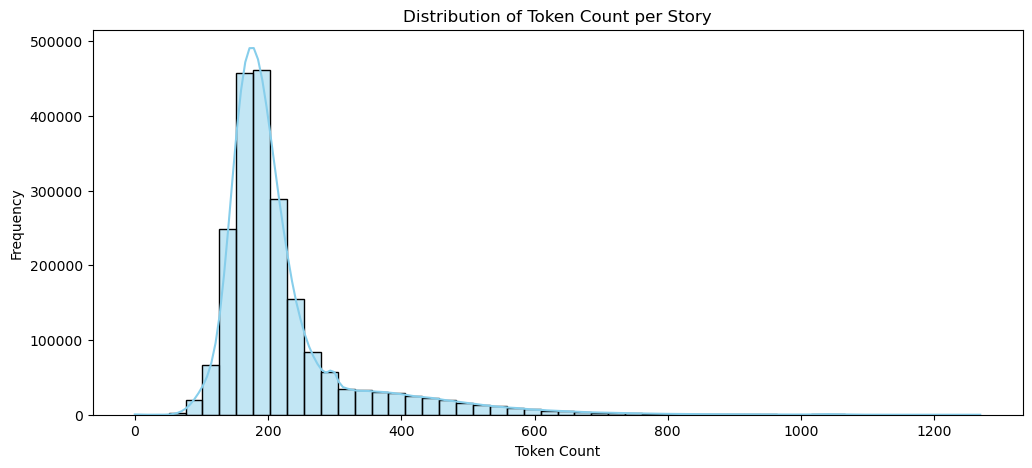

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(token_counts, kde=True, bins=50, color='skyblue')
plt.title("Distribution of Token Count per Story")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

## 🟠 Analyzing Short Stories

In [ ]:
unique_length = np.unique(token_counts)
print(unique_length[:10])

[ 0  6  9 11 12 13 14 15 17 19]


In [ ]:
# Get unique lengths
target_lengths = unique_length[:10]

# Track how many samples we've printed per length
samples_per_length = defaultdict(int)
max_samples = 5  # max samples per token length

for idx, tokens in enumerate(tokenized_train_samples):
    token_len = len(tokens)

    if token_len in target_lengths and samples_per_length[token_len] < max_samples:
        count = samples_per_length[token_len] + 1
        print(f"\n📘 Length: {token_len}")
        pprint(dataset["train"][idx]["text"])
        samples_per_length[token_len] += 1

    # Stop if we've collected all 10 * 5 = 50 samples
    if sum(samples_per_length.values()) >= len(target_lengths) * max_samples:
        break



📘 Length: 0
''

📘 Length: 0
''

📘 Length: 0
''

📘 Length: 0
''

📘 Length: 0
''

📘 Length: 11
'One day a lady entered the room. She was mod'

📘 Length: 6
'Once upon a time, there'

📘 Length: 11
'Once upon a time, there was a silly little bunny'

📘 Length: 9
'Once upon a time, in a quiet little'

📘 Length: 17
'Once upon a time, in a big tree, there was a thoughtful raven. The'

📘 Length: 13
'Once upon a time, there was a boy named Timmy.'

📘 Length: 19
('Once upon a time, there was a little girl named Lily who loved fairies. She '
 'would')

📘 Length: 15
'Once upon a time, there was a little girl named Helga. Hel'

📘 Length: 11
'Once upon a time, there was a silly little bunny'

📘 Length: 12
'Once upon a time, in a wide, hot desert,'

📘 Length: 14
'Once upon a time, there was a happy baby named Jack. Jack'

📘 Length: 14
'Once upon a time, a chubby cat named Kitty lived in a'


## 🟠 Average story length (words, sentences, paragraphs)

In [ ]:
print(f"🔹 Average word count per story      → Mean: {np.mean(word_counts):.2f} | Median: {np.median(word_counts)} | Mode: {mode(word_counts).mode}")
print(f"🔹 Average sentence count per story  → Mean: {np.mean(sentence_counts):.2f}")
print(f"🔹 Average paragraph count per story → Mean: {np.mean(paragraph_counts):.2f}")

🔹 Average word count per story      → Mean: 203.37 | Median: 177.0 | Mode: 168
🔹 Average sentence count per story  → Mean: 18.29
🔹 Average paragraph count per story → Mean: 5.12


## 🟠 Most common unigrams, bigrams, trigrams

In [ ]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.util import ngrams

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Howsam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Howsam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Helper functions
def clean_text(text):
    text = text.lower()
    return text.strip()

def get_top_ngrams(ngrams_list, n=20):
    counter = Counter(ngrams_list)
    return counter.most_common(n)

In [ ]:
# Preprocessing and aggregation
all_words = []
all_bigrams = []
all_trigrams = []

for sample in tqdm(dataset['validation']):  # Limit for performance (you can increase)
    text = clean_text(sample['text'])
    words = word_tokenize(text)
    all_words.extend(words)
    all_bigrams.extend([' '.join(bg) for bg in ngrams(words, 2)])
    all_trigrams.extend([' '.join(tg) for tg in ngrams(words, 3)])

100%|███████████████████████████████████████████████████████████████████████████| 21990/21990 [00:47<00:00, 463.96it/s]


In [ ]:
top_unigrams = get_top_ngrams(all_words)
top_bigrams = get_top_ngrams(all_bigrams)
top_trigrams = get_top_ngrams(all_trigrams)

print("\n🔸 Top 20 Unigrams:")
print(top_unigrams)

print("\n🔸 Top 20 Bigrams:")
print(top_bigrams)

print("\n🔸 Top 20 Trigrams:")
print(top_trigrams)


🔸 Top 20 Unigrams:
[('.', 358849), ('the', 204873), ('and', 181817), (',', 174211), ('to', 129273), ('a', 117121), ('was', 99492), ('he', 81788), ('she', 78131), ('it', 71460), ('they', 64992), ('her', 51001), ("''", 46793), ('``', 46777), ('said', 35139), ('!', 33317), ('his', 33039), ('in', 32774), ('with', 31619), ('lily', 30740)]

🔸 Top 20 Bigrams:
[('. she', 43541), ('. he', 42399), ('. they', 38209), ('. the', 29535), (', ``', 22586), ('was a', 20609), ('. ``', 19850), ('in the', 18923), ('it was', 17512), ('said ,', 17236), ('day ,', 16767), ('one day', 16107), ('. it', 15527), ('to the', 15483), (". ''", 15241), ('there was', 15234), ('. one', 14500), ("! ''", 14025), ('upon a', 13605), ('a time', 13579)]

🔸 Top 20 Trigrams:
[('said , ``', 15326), ('there was a', 14402), ('one day ,', 14009), ('. one day', 13633), ('once upon a', 13545), ('upon a time', 13536), ('a time ,', 10655), (', there was', 10240), ('time , there', 10039), ('and said ,', 7637), ('. it was', 7169), ('was

## 🟠 Extracting the Top 10,000 Most Frequent Tokens from the Dataset

In [ ]:
# Counter to keep track of token frequencies
token_counter = Counter()

# Iterate through all token IDs and update the counter
for tokens in tqdm(tokenized_train_samples, desc="Counting token frequencies"):
    token_counter.update(tokens)

# Get the 10,000 most frequent tokens
top_10k_tokens = [token_id for token_id, _ in token_counter.most_common(10_000)]

# Save to file for future use
with open("top_10k_tokens.txt", "w") as f:
    for token_id in top_10k_tokens:
        f.write(f"{token_id}\n")

print("\n🔹 10K top tokens saved to top_10k_tokens.txt")


Counting token frequencies: 100%|█████████████████████████████████████████| 2119719/2119719 [01:47<00:00, 19688.41it/s]



🔹 10K top tokens saved to top_10k_tokens.txt


In [ ]:
print(f"🔹 Unique tokens: {len(token_counter)}")

🔹 Unique tokens: 29251


### 🟡 Print rare tokens

In [ ]:
from rich.console import Console
from rich.text import Text

In [ ]:
# Initialize rich console for colored output
console = Console()

# Load tokenizer and dataset
tokenizer = tiktoken.get_encoding("gpt2")

# Load list of allowed tokens (top 10k)
with open("top_10k_tokens.txt", "r") as f:
    top_10k_tokens = set(int(line.strip()) for line in f)

# Select a random story from the dataset
sample = random.choice(dataset['train'])
text = sample["text"]

# Tokenize the text without special tokens
tokens = tokenizer.encode(text)

# Build styled text using rich
styled_text = Text()
for token_id in tokens:
    token_str = tokenizer.decode([token_id])

    if token_id in top_10k_tokens:
        styled_text.append(token_str, style="white")
    else:
        styled_text.append(token_str, style="bold yellow")

# Print both the original and the color-highlighted version
console.rule("🔍 Tokenized View (unk tokens in yellow)")
console.print(styled_text)


──────────────────────────────────── 🔍 Tokenized View (unk tokens in yellow) ─────────────────────────────────────

Tommy was a little bunny. He was hopping through the meadow on his way to see his friend Farley the frog. Even 
though Tommy was excited to see his friend, he felt frustrated. He hadn't seen Farley in a long time and the memory
of their last adventure was fading. 

Tommy let out a big yawn as he hopped down a narrow path. When he reached the edge of the forest and saw Farley, 
Tommy couldn't help but smile. His friend was smiling wide, too and Tommy felt his excitement grow even more.

The two friends hugged and Tommy felt a wave of warmth fill him. They spent the rest of the day talking and 
playing, exploring the nearby waterfall and the trails. By evening, they were both tired and Tommy yawned again. 

The sun was setting, but Tommy was happy and content. He felt his frustrations gone and the memory of their 
adventure would always stay with him.

## 🟠 Vocabulary richness (type-token ratio)

In [ ]:
# Calculate Type-Token Ratio (TTR)
type_token_ratio = len(token_counter) / sum(token_counter.values())
print(f"🔹 Vocabulary Richness (TTR): {type_token_ratio:.4f}")

🔹 Vocabulary Richness (TTR): 0.0001


# 🟣 **Pre-processing**

# 🔴 **Tokenization**

In [ ]:
# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="|<unk>|"))

# Use a pre-tokenizer to split text into words
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

# Initialize a BPE trainer
trainer = trainers.BpeTrainer(
    vocab_size=10_000,  # Set the vocabulary size
    special_tokens=["|<unk>|", "<|endoftext|>"],
    min_frequency=2,  # Set the minimum frequency of tokens
    )

# Train the tokenizer on a custom dataset
tokenizer.train_from_iterator(dataset["train"]["text"], trainer)

# Add special tokens
tokenizer.post_processor = processors.TemplateProcessing(
    single="<|endoftext|> $A",
    special_tokens=[("<|endoftext|>", tokenizer.token_to_id("<|endoftext|>"))],
)

# Add decoder
tokenizer.decoder = decoders.ByteLevel(add_prefix_space=False)

# Save the trained tokenizer
tokenizer.save("bpe-tokenizer_tinystories.json")

#
print(f"🎉 Tokenizer training complete!")
print(f"🔹 Vocabulary size: {tokenizer.get_vocab_size():,} tokens")

In [ ]:
sent = 'They played together all day and became best friends.'
tokens = tokenizer.encode(sent)
print(tokens.ids)
print(tokens.tokens)

pprint(tokenizer.decode(tokens.ids))

In [ ]:
list_sent = ['They played together all day and became best friends.',
             'They played together all day and became best friends.',
             'They played together all day and became best friends.']
string = ' <|endoftext|> '.join(list_sent) + ' <|endoftext|>'
print(string)
print(tokenizer.encode(string).ids)

### 🟡 Save the tokens for future use

In [ ]:
# Tokenization {train}
tokenized_train_samples = []
for item in tqdm(dataset["train"], desc="Tokenizing Train Set"):
    input_ids = tokenizer.encode(item["text"]).ids
    tokenized_train_samples += input_ids

# Save tokens as a pytorch file
torch.save(torch.LongTensor(tokenized_train_samples), 'tokenized-train-samples_vocab-10k.pt')

Tokenizing Train Set: 100%|████████████████████████████████████████████████| 2119719/2119719 [25:33<00:00, 1382.41it/s]


In [ ]:
# Tokenization {validation}
tokenized_valid_samples = []
for item in tqdm(dataset["validation"], desc="Tokenizing Validation Set"):
    input_ids = tokenizer.encode(item["text"]).ids
    tokenized_valid_samples += input_ids

# Save tokens as a pytorch file
torch.save(torch.tensor(tokenized_valid_samples), 'tokenized-valid-samples_vocab-10k.pt')

Tokenizing Validation Set: 100%|███████████████████████████████████████████████| 21990/21990 [00:15<00:00, 1413.81it/s]


# 🔴 **Custom Dataset**

In [ ]:
# Load tokens from pytorch file
tokenized_train_samples = torch.load('tokenized-train-samples_vocab-10k.pt')
tokenized_valid_samples = torch.load('tokenized-valid-samples_vocab-10k.pt')
tokenized_train_samples.shape, tokenized_valid_samples.shape

(torch.Size([464965814]), torch.Size([4673588]))

## 🟠 `TensorDataset()`

In [ ]:
seq_len = 128  # Desired sequence length for each row
tokenized_train_samples = prepare_data(tokenized_train_samples, seq_len)
tokenized_train_samples.shape

torch.Size([3632545, 128])

In [ ]:
train_set = TensorDataset(tokenized_train_samples[:, :-1], tokenized_train_samples[:, 1:])
train_set[3_600_000]

(tensor([ 159, 1036, 1329,   15,  195, 4390,  865,  155,  851,  161,  295,   13,
          212,  159, 6765,  243,  159, 1455,   13,  178,  155, 2168, 4390,   15,
          304,  132,  269, 1036,  178,  527,  161,  340,  162,  618,  452,   13,
          306,  159, 4390, 1829,  248,  963,  161,  394,   15,  211,  634,  159,
         1036,  253,  200,  178,  670,  155,  302, 4390,  406,    2,  195, 1036,
          394,  161,  894,   15,  304,  132,  269,  802,  375, 2208,  159,  252,
          501,  161, 1830,  159, 1455,   15,  854,  200,  178,  292,  162,  332,
           13,  159, 1036,  894,  212, 5388,  238,  159, 4390,   15,  305,  178,
          155, 1360,  252,  161,  258,  792,  599,  258,  426,  650, 1765,  159,
          917,  258, 1550,   15,    1, 1283,  161,  248,  261,  364,  162,  159,
         2124,   15,  211,  309,  686,  782,   15], dtype=torch.int32),
 tensor([1036, 1329,   15,  195, 4390,  865,  155,  851,  161,  295,   13,  212,
          159, 6765,  243,  159, 1455

In [ ]:
# train_set = TensorDataset(tokenized_train_samples)
# train_set[0]

In [ ]:
train_iter = iter(train_set)

In [ ]:
%timeit next(train_iter)

6.63 µs ± 241 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## 🟠 Custom Class

In [ ]:
class TinyStoriesDataset(Dataset):

    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = prepare_data(data, seq_len+1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample[:-1], sample[1:]

In [ ]:
train_set = TinyStoriesDataset(tokenized_train_samples, 128)
train_set.data.shape, len(train_set), train_set[0]

(torch.Size([3604352, 129]),
 3604352,
 (tensor([   1,  316,  252,   13,  155,  293,  342,  396,  260,  491,  155, 3628,
           212,  205,  654,   15,  209,  599,  200,  178, 2858,  162,  255,  238,
           200,  683,  200,  178, 2012,   15,  260,  340,  162,  844,  159, 3628,
           238,  205,  261,   13,  246,  234,  356, 5090,  155, 2120,  241,  205,
          2392,   15,  132,  132,  239,  364,  162,  205,  261,  161,  223,   13,
           225,  666,   13,  231,  491,  636, 3628,   15, 1176,  242,  844,  200,
           238,  414,  161, 5090,  547, 2392,  373,  761,  261,  394,  161,  223,
            13,  225,  727,   13,  260,   13,  259,  367,  844,  159, 3628,  161,
          1200,  522, 2392,  311,  132,  132, 4517,   13,  258, 1550,  159, 3628,
           161, 7822,  159, 2120,  241,  260,  267, 2392,   15,  305,  178,  281,
          2858,  262,  344,  683,  258,  325, 2394,  161], dtype=torch.int32),
  tensor([ 316,  252,   13,  155,  293,  342,  396,  260,  491

In [ ]:
x, y = train_set[0]
x.shape, y.shape

(torch.Size([128]), torch.Size([128]))

In [ ]:
train_iter = iter(train_set)

In [ ]:
%timeit next(train_iter)

9.7 µs ± 312 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# 🔴 **Dataloader**

In [ ]:
tokenized_train_samples = torch.load('tokenized-train-samples_vocab-10k.pt')
tokenized_valid_samples = torch.load('tokenized-valid-samples_vocab-10k.pt')

train_set = TinyStoriesDataset(tokenized_train_samples, seq_len=128)
valid_set = TinyStoriesDataset(tokenized_valid_samples, seq_len=128)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True)#, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, pin_memory=True)#, num_workers=4)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([32, 128]), torch.Size([32, 128]))

In [ ]:
for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 128]) torch.Size([32, 128])


In [ ]:
len(train_loader), len(valid_loader)

(112638, 1133)

In [ ]:
len(train_loader) / (20*60)

93.865

In [ ]:
train_iter = iter(train_loader)

In [ ]:
%timeit next(train_iter)

465 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 🔴 **Alternative Versions!**

## 🟠 Iterable Dataset

In [ ]:
def simple_generator():
    yield 1
    yield 2
    yield 3

for g in simple_generator():
    print(g)


1
2
3


In [ ]:
class TinyStoriesDataset(IterableDataset):

    def __init__(self, text_samples, tokenizer, group_size=10, seq_len=256):
        """
        Args:
            text_samples (List[str]): List of raw text strings (e.g., stories).
            tokenizer (Tokenizer): A HuggingFace-style tokenizer with .encode().ids support.
            group_size (int): Number of text samples to concatenate per chunk before tokenization.
            seq_len (int): Target length of each token sequence for training.
        """
        self.text_samples = text_samples
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.group_size = group_size

    def __iter__(self):
        buffer = []

        # Iterate through the dataset in chunks of `group_size`
        for i in range(0, len(self.text_samples), self.group_size):
            # Join multiple stories with a special token and tokenize the batch
            sample = ' <|endoftext|> '.join(self.text_samples[i:i + self.group_size]) + ' <|endoftext|>'
            tokens = self.tokenizer.encode(sample).ids
            buffer += tokens

            # Yield token chunks of size seq_len + 1 for input-target training pairs
            yield from (
                torch.from_numpy(np.array(buffer[j:j + self.seq_len+1], dtype=np.int64))
                for j in range(0, len(buffer) - self.seq_len, self.seq_len)
            )

            # Keep leftover tokens that didn't form a full chunk
            buffer = buffer[(len(buffer) // self.seq_len) * self.seq_len:]


In [ ]:
tokenizer = Tokenizer.from_file("bpe-tokenizer_tinystories.json")
dataset = load_dataset("roneneldan/TinyStories")

train_set = TinyStoriesDataset(dataset["train"]["text"], tokenizer, group_size=10, seq_len=128)
test_set = TinyStoriesDataset(dataset["validation"]["text"], tokenizer, group_size=10, seq_len=128)

In [ ]:
next(iter(train_set)).shape

torch.Size([129])

In [ ]:
train_iter = iter(train_set)

In [ ]:
%timeit next(train_iter)

445 µs ± 45.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=32, pin_memory=True)

In [ ]:
train_iter = iter(train_loader)

In [ ]:
%timeit next(train_iter)

13.5 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 🟠 Andrej Karpathy [🔗](https://github.com/karpathy/nano-llama31/blob/master/tiny_stories.py)